In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:

# Unzipping the dataset
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/data2 (2).zip'  # Change this to the path of your zip file
extraction_path = '/content/dataset/'

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Verify extraction
os.listdir(extraction_path)

['TrafficAI vision Dataset (2)']

In [3]:
import os
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import numpy as np
from skimage.restoration import denoise_bilateral

# Paths
dataset_path = '/content/dataset/TrafficAI vision Dataset (2)'  # Change this to your dataset path
output_path = '/content/resized_dataset/'  # Path to save processed images

# Create the output directory if it doesn't exist
os.makedirs(output_path, exist_ok=True)

# Target size for resizing
IMAGE_SIZE = (224, 224)

# Function to load an image using OpenCV
def load_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    return img

# 1. Image Normalization
def normalize_image(image):
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

# 2. Data Augmentation using Keras' ImageDataGenerator
def augment_image(image):
    datagen = ImageDataGenerator(
        rotation_range=40,  # Random rotation between 0 and 40 degrees
        width_shift_range=0.2,  # Shift image horizontally (up to 20% of width)
        height_shift_range=0.2,  # Shift image vertically (up to 20% of height)
        shear_range=0.2,  # Shear the image
        zoom_range=0.2,  # Randomly zoom into images
        horizontal_flip=True,  # Randomly flip images
        fill_mode='nearest'  # Fill in newly created pixels after transformations
    )

    # Expand dimensions for single image (Keras expects batches)
    image = np.expand_dims(image, axis=0)
    augmented_image = next(datagen.flow(image, batch_size=1))[0]  # Get one augmented image
    return augmented_image

# 3. Resizing the image using OpenCV
def resize_image(image, target_size=(224, 224)):
    resized_image = cv2.resize(image, target_size)
    return resized_image

# 4. Denoising using skimage with channel_axis argument for RGB images
"""def denoise_image(image):
    # Apply bilateral denoising with channel_axis for multichannel (RGB) images
    denoised_image = denoise_bilateral(image, sigma_color=0.05, sigma_spatial=15, channel_axis=-1)
    return denoised_image"""

# Putting it all together: Preprocess the image (resize, denoise, normalize, augment)
def preprocess_image(image_path):
    # Step 1: Load image
    image = load_image(image_path)

    # Step 2: Resize image
    resized_image = resize_image(image, target_size=(224, 224))

    # Step 3: Denoise image
    #denoised_image = denoise_image(resized_image)

    # Step 4: Normalize image
    normalized_image = normalize_image(resized_image)

    # Step 5: Augment image
    augmented_image = augment_image(normalized_image)

    return augmented_image

# Iterate over the dataset directory, process, and save the images
for root, dirs, files in os.walk(dataset_path):  # Iterate through all folders and files
    for file in files:
        if file.endswith(('.png', '.jpg', '.jpeg')):  # Check for image files
            img_path = os.path.join(root, file)  # Full path to the image

            # Preprocess the image (resize, denoise, normalize, augment)
            processed_image = preprocess_image(img_path)

            # Save the processed image with the same directory structure
            relative_path = os.path.relpath(root, dataset_path)  # Keep folder structure intact
            save_dir = os.path.join(output_path, relative_path)  # Create the directory in the output folder
            os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

            # Save the processed image using PIL
            processed_image_pil = Image.fromarray((processed_image * 255).astype(np.uint8))  # Convert back from [0, 1] to [0, 255]
            processed_image_pil.save(os.path.join(save_dir, file))  # Save the image

print("Processing completed and all images saved.")


Processing completed and all images saved.


In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image size and batch size
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

# Data Augmentation & Preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Rescale pixel values from 0-255 to 0-1
    rotation_range=20,        # Rotate images for data augmentation
    width_shift_range=0.2,    # Shift width
    height_shift_range=0.2,   # Shift height
    shear_range=0.2,          # Shear transformation
    zoom_range=0.2,           # Random zoom
    horizontal_flip=True,     # Flip images horizontally
    validation_split=0.2      # 20% of the dataset for validation
)

# Train set
train_generator = train_datagen.flow_from_directory(
    '/content/resized_dataset/TrafficAI vision Dataset/train',           # Path to dataset folder
    target_size=IMAGE_SIZE,    # Resize images to 224x224
    batch_size=BATCH_SIZE,
    class_mode='categorical',  # For multi-class classification
    subset='training'          # Set as training data
)

# Validation set
validation_generator = train_datagen.flow_from_directory(
    '/content/resized_dataset/TrafficAI vision Dataset/test',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'        # Set as validation data
)


Found 2253 images belonging to 6 classes.
Found 60 images belonging to 6 classes.


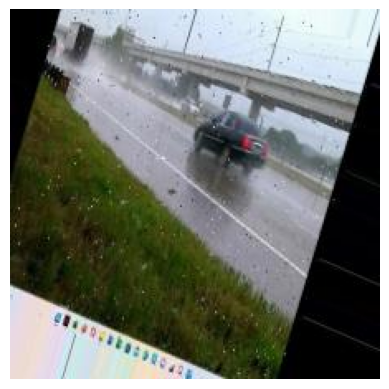

In [8]:
import cv2
from matplotlib import pyplot as plt

# Load the image using OpenCV
image_path = '/content/resized_dataset/TrafficAI vision Dataset/test/class 2/Screenshot--310-_png_jpg.rf.20b5d59e707a26bee47bbe1d8f7a18a5.jpg'  # Change this to the path of your image
img = cv2.imread(image_path)

# Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Display the image using Matplotlib
plt.imshow(img_rgb)
plt.axis('off')  # Hide axis
plt.show()


In [11]:
import tensorflow as tf

# Define the input shape explicitly
input_shape = (224, 224, 3)

# Load the VGG16 model with pre-trained weights and without the top classification layers
base_model = tf.keras.applications.VGG16(input_shape=input_shape,
                                         include_top=False,  # Exclude top classification layers
                                         weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Add new, more complex layers on top of VGG16
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=input_shape),  # Explicitly define the input layer
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),             # Reduce spatial dimensions

    # Add multiple dense layers to increase complexity
    tf.keras.layers.Dense(2048, activation='relu'),       # First dense layer with 2048 units
    tf.keras.layers.BatchNormalization(),                 # Batch normalization for faster convergence
    tf.keras.layers.Dropout(0.5),                         # Dropout to prevent overfitting

    tf.keras.layers.Dense(1024, activation='relu'),       # Second dense layer with 1024 units
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(512, activation='relu'),        # Third dense layer with 512 units
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(256, activation='relu'),        # Fourth dense layer with 256 units
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),

    # Final output layer for 13 classes
    tf.keras.layers.Dense(6, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2048)                │       1,050,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 6)                   │           1,542 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,536,518 (70.71 MB)

 Trainable params: 3,814,150 (14.55 MB)

 Non-trainable params: 14,722,368 (56.16 MB)

In [13]:
for x, y in validation_generator:
    print(x.shape, y.shape)  # Ensure the generator is yielding data correctly
    break


(32, 224, 224, 3) (32, 6)


In [14]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,  # You can increase the number of epochs
)

Epoch 1/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 32s 420ms/step - accuracy: 0.7737 - loss: 0.7280 - val_accuracy: 0.5833 - val_loss: 1.8775
Epoch 2/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 32s 395ms/step - accuracy: 0.8279 - loss: 0.5870 - val_accuracy: 0.6167 - val_loss: 1.6164
Epoch 3/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 407ms/step - accuracy: 0.8473 - loss: 0.4820 - val_accuracy: 0.7167 - val_loss: 1.1468
Epoch 4/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 41s 409ms/step - accuracy: 0.8310 - loss: 0.5023 - val_accuracy: 0.7333 - val_loss: 1.1654
Epoch 5/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 32s 401ms/step - accuracy: 0.8539 - loss: 0.4467 - val_accuracy: 0.7667 - val_loss: 1.0215
Epoch 6/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 401ms/step - accuracy: 0.8645 - loss: 0.4283 - val_accuracy: 0.7167 - val_loss: 1.1995
Epoch 7/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 400ms/step - accuracy: 0.8489 - loss: 0.4327 - val_accuracy: 0.7333 - val_loss: 0.9082
Epoch 8/30
71/71 ━━━━━━━━━━━━━━━━━━━━ 31s 405ms/step - accuracy: 0.8557 - loss: 0.4595 - val_accu

Text(0, 0.5, 'accuracy')

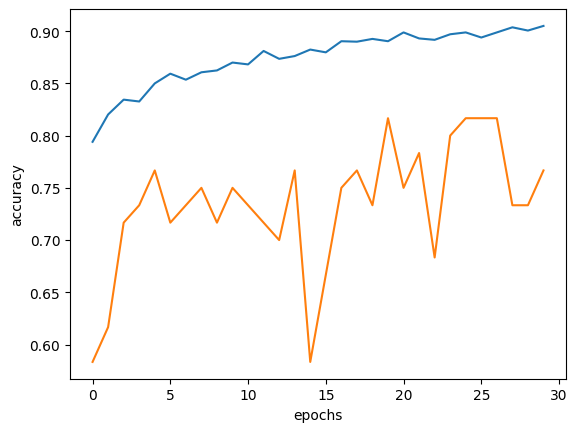

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel('epochs')
plt.ylabel('accuracy')

In [16]:
# Evaluate the model
loss, accuracy = model.evaluate(validation_generator)
print(f'Validation Accuracy: {accuracy*100:.2f}%')


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 458ms/step - accuracy: 0.8042 - loss: 0.7923
Validation Accuracy: 80.00%
